# High-power GM-VAE bi-modal clustering to separate SMBA and KIA

The purpose of this notebook is to test whether GM-VAE can successfully discover a simple structure hidden in labelled data. This gives us the confidence to apply GM-VAE to unlabelled data. The difficulty of applying GM-VAE to unlabelled data is that the resulting clusters are difficult to interpret with just examples. 
- They must be interpreted using summarizing statistics and hints (broad labels that don't necessary align with the clustering results, e.g., from which level).
- Analysis to perform: 
    - Closeness to training data distribution in terms of metrics
    - Novelty-quality tradeoff (we want to increase novelty without sacrificing quality)
    - Interpretation of resulting clusters (since GM-VAE is not ad-hoc, its clusters may be more meaningful)

## Import Libraries

In [22]:
import json

import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat

import sys
sys.path.append('./pytorch')
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

from model.GMVAE import *
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [23]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

Load SMB.

In [24]:
smb_int = open_json_as_nparray('smbWithPath-allLevels-chunks-int.json')

In [25]:
smb_onehot = np.eye(18)[smb_int]
smb_onehot.shape

(2698, 16, 16, 18)

In [26]:
smb_onehot = smb_onehot.reshape(
    smb_onehot.shape[0], 
    smb_onehot.shape[1] * smb_onehot.shape[2] * smb_onehot.shape[3]
)
smb_onehot.shape

(2698, 4608)

In [27]:
smb_labels = np.zeros(smb_onehot.shape[0])
smb_labels.shape

(2698,)

Load KI.

In [28]:
ki_int = open_json_as_nparray('kiWithPath-allLevels-chunks-int.json')

In [29]:
ki_int = ki_int + 12  # plus 12 because there were 12 encodings for mario
ki_int[ki_int == 18] = 11  # set the 18th index, which is P, to the path index for mario

In [30]:
ki_onehot = np.eye(18)[ki_int]
ki_onehot.shape

(1142, 16, 16, 18)

In [31]:
# ki_onehot_zero_padded = np.zeros(
#     (
#     ki_onehot.shape[0], 
#     16, 16,
#     len(np.unique(smb_int))
#     )
# )

In [32]:
# ki_onehot_zero_padded.shape

In [33]:
# ki_onehot_zero_padded[
#     :ki_onehot.shape[0],
#     :ki_onehot.shape[1],
#     :ki_onehot.shape[2],
#     :ki_onehot.shape[3]
# ] = ki_onehot

In [34]:
# ki_onehot_zero_padded.shape

In [35]:
# ki_onehot_zero_padded[:,:,:,6].max(), ki_onehot_zero_padded[:,:,:,7].max()

In [36]:
# ki_onehot_zero_padded = ki_onehot_zero_padded.reshape(
#     ki_onehot_zero_padded.shape[0], 
#     ki_onehot_zero_padded.shape[1] * ki_onehot_zero_padded.shape[2] * ki_onehot_zero_padded.shape[3]
# )
# ki_onehot_zero_padded.shape

In [37]:
ki_onehot = ki_onehot.reshape(ki_onehot.shape[0], -1)
ki_onehot.shape

(1142, 4608)

In [38]:
ki_labels = np.ones(len(ki_onehot))

Create labels.

In [39]:
labels = np.concatenate([smb_labels, ki_labels])
labels.shape, labels

((3840,), array([0., 0., 0., ..., 1., 1., 1.]))

In [40]:
chunks = np.concatenate([smb_onehot, ki_onehot])

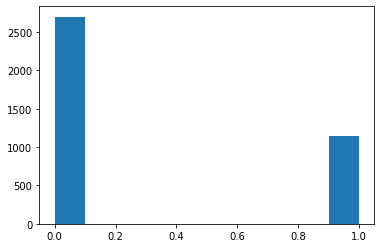

In [41]:
plt.hist(labels)
plt.show()

## Input Parameters

In [51]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=100,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=2,
                    help='number of classes (default: 10)')  # edited for this task
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=4608, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=0.9, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [52]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
    torch.cuda.manual_seed(SEED)

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [53]:
from torch.utils.data import TensorDataset, DataLoader

In [54]:
assert args.train_proportion != 1

In [55]:
def partition_dataset(n, proportion=1):
    train_num = int(n * proportion)
    indices = np.random.permutation(n)
    train_indices, val_indices = indices[:train_num], indices[train_num:]
    return train_indices, val_indices

train_indices, val_indices = partition_dataset(len(chunks), args.train_proportion)
train_ds = TensorDataset(torch.from_numpy(chunks).float(), torch.from_numpy(labels).long())
train_dl = DataLoader(train_ds, batch_size=args.batch_size, sampler=SubsetRandomSampler(train_indices))
valid_dl = DataLoader(train_ds, batch_size=args.batch_size_val, sampler=SubsetRandomSampler(val_indices))

## Train Model

In [71]:
# Model Initialization
gmvae = GMVAE(args)

In [77]:
# history_loss = gmvae.train(train_dl, valid_dl)

In [75]:
# torch.save(gmvae.network.state_dict(), 'high_param_gmvae_binary.pth')

In [76]:
gmvae.network.load_state_dict(torch.load('high_param_gmvae_binary.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

## Image Reconstruction

In [78]:
original, reconstructed = gmvae.reconstruct_data(valid_dl, 15)  

In [85]:
original_int = original.reshape(15, 16, 16, 18).argmax(axis=-1)
reconstructed_int = reconstructed.reshape(15, 16, 16, 18).argmax(axis=-1)

In [88]:
def get_classes(chunks_int):
    classes = []
    for i in chunks_int:
        if i.max() == 17:
            classes.append('kia')
        else:
            classes.append('smba')
    return np.array(classes)

In [89]:
get_classes(original_int)

array(['smba', 'kia', 'kia', 'smba', 'smba', 'smba', 'smba', 'smba',
       'kia', 'smba', 'kia', 'kia', 'kia', 'kia', 'smba'], dtype='<U4')

In [82]:
org_classes = get_classes(original_int)
rec_classes = get_classes(reconstructed_int)
assert np.sum(org_classes == rec_classes) == len(org_classes)

In [83]:
def get_images(chunks_int):
    images = []
    for game, chunk in zip(get_classes(chunks_int), chunks_int):
        images.append(vglc_with_path_encodings.array_to_image([chunk], game=game)[0])
    return images

In [84]:
org_images = get_images(original_int)
rec_images = get_images(reconstructed_int)
len(org_images), len(rec_images)

KeyError: 15

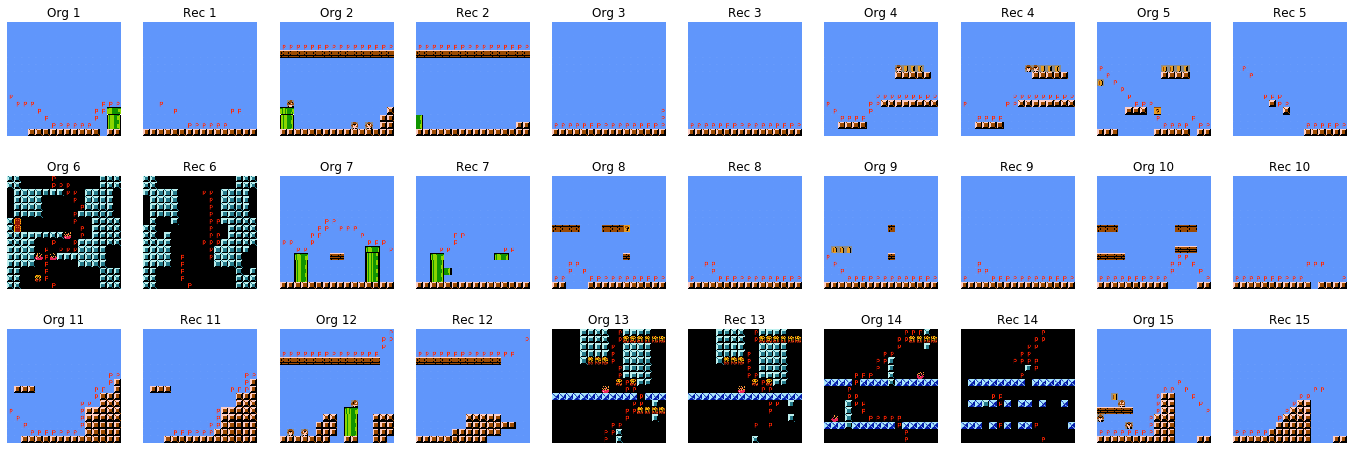

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(24, 8))
axes = axes.flatten()
nrows, ncols = 3, 10

org_idxs = np.arange(0, 29, 2)
rec_idxs = org_idxs + 1

for idx in org_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(org_images[idx // 2]))
    ax.set_title(f'Org {idx // 2 + 1}')
    
    ax.axis('off')

for idx in rec_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(rec_images[idx // 2]))
    ax.set_title(f'Rec {idx // 2 + 1}')

    ax.axis('off')
    
plt.show()

## Random Generation per Category

In [27]:
idx2game = {
    0:'smba',
    1:'kia'
}

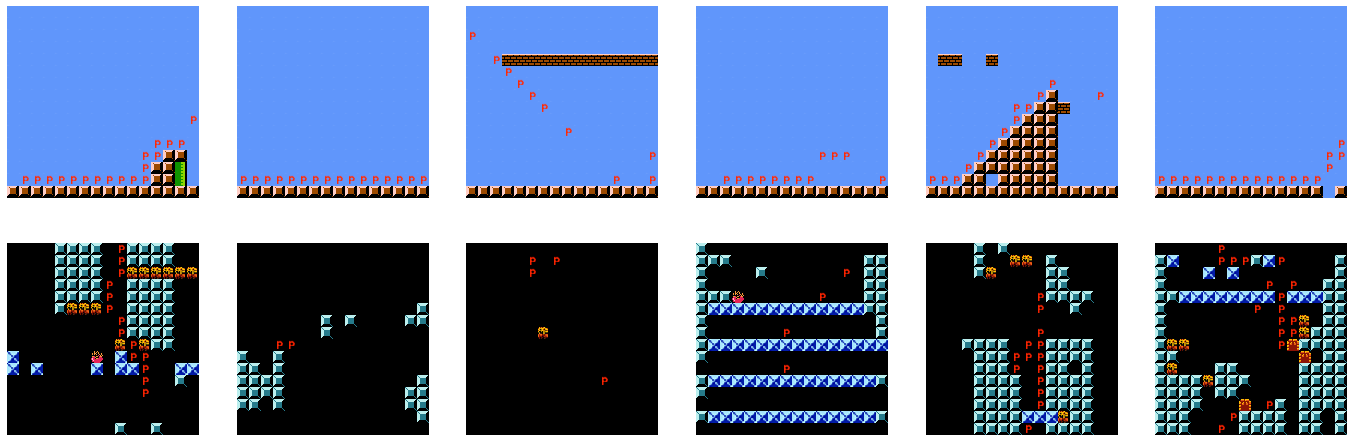

In [28]:
def display_random_generation(generated, num_classes, n=10):
    plt.figure(figsize=[24,8])
    for c in range(num_classes):
        for i in range(n):
            plt.subplot(num_classes, n, (c * n) + i + 1)
            chunk_int = generated[(c * n) + i].reshape(16, 16, 12).argmax(axis=-1)
            chunk_pix = vglc_with_path_encodings.array_to_image([chunk_int], game=idx2game[c])[0]
            plt.imshow(chunk_pix)
            plt.gray()
            plt.axis('off')
    plt.show()

elem_per_category = 6
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

In [90]:
generated = gmvae.random_generation(5000)

In [96]:
generated_int = generated.reshape(-1, 16, 16, 18).argmax(-1).reshape(-1, 16*16)
generated_int.shape

(10000, 256)

In [105]:
smb_proportions = np.sum(generated_int < 11, axis=1) / 256

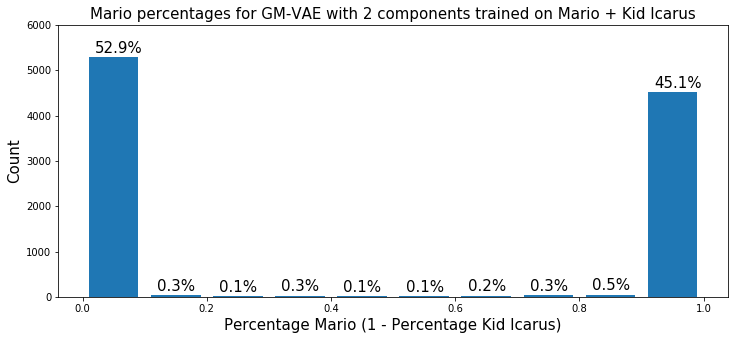

In [145]:
plt.figure(figsize=(12, 5))
counts, bins, patches = plt.hist(smb_proportions, rwidth=0.8)
for p in patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/np.sum(counts))
    x = p.get_x() + p.get_width() / 2 - 0.03
    y = p.get_y() + p.get_height() + 100
    plt.annotate(percentage, (x, y), fontsize=15)
plt.ylim(0, 6000)
plt.title('Mario percentages for GM-VAE with 2 components trained on Mario + Kid Icarus', fontsize=15)
plt.xlabel('Percentage Mario (1 - Percentage Kid Icarus)', fontsize=15)
plt.ylabel('Count', fontsize=15)
# plt.savefig('Mario percentages for GM-VAE with 2 components trained on Mario + Kid Icarus.png')
plt.show()

## Visualization of the feature latent space

In [50]:
# get feature representations
test_features, test_labels = gmvae.latent_features(train_dl, True)

In [51]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm

first_n = 1000
tsne_features = TSNE(n_components=2).fit_transform(test_features[:first_n])

In [52]:
test_labels_subset = test_labels[:first_n]
tsne_features_smba = tsne_features[test_labels_subset == 0]
tsne_features_kia  = tsne_features[test_labels_subset == 1]

In [53]:
X_, Y_ = np.s_[:,0], np.s_[:,1]

In [54]:
import seaborn as sns

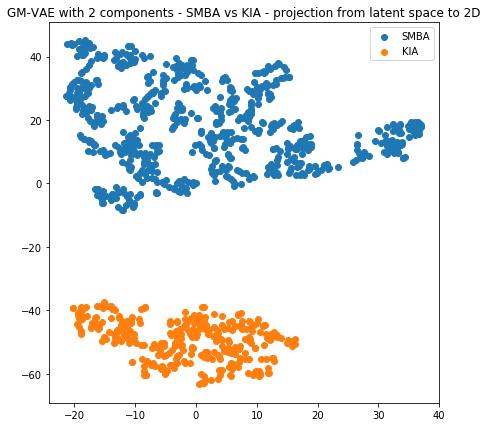

In [64]:
fig = plt.figure(figsize=(7, 7))

plt.scatter(tsne_features_smba[X_], tsne_features_smba[Y_], label='SMBA')
plt.scatter(tsne_features_kia[X_], tsne_features_kia[Y_], label='KIA')

plt.title('GM-VAE with 2 components - SMBA vs KIA - projection from latent space to 2D')
plt.legend()
plt.savefig('gmvae2_tsne.png')